# Text Analytics -- Car Forum Exploration <br>
*Diwei Zhu, Yichen Wang, Alice Liu, Kexin Wang, Jiahua Liang, Ziye Zhang* <br>
________________________________________________________________________________________


# 1. Data Scraping

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import csv
# from requests_html import HTMLSession

In [2]:
entries = []
entry = []
urlnumber = 200 # Give the page number to start with


while urlnumber < 310: # Give the page number to end with
    #print(urlnumber)
    url = 'http://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p%d' % (urlnumber,) # Give the url of the forum, excluding the page number in the hyperlink

    try:
        r = requests.get(url, timeout = 10) # Sending a request to access the page
    except Exception as e:
        print("Error message:",e)
        break;

    data = r.text
    
    soup = BeautifulSoup(data, 'lxml') # Getting the page source into the soup
    
    for div in soup.find_all('div'):
        entry = []
        if(div.get('class') != None and div.get('class')[0] == 'Comment'): # A single post is referred to as a comment. Each comment is a block denoted in a div tag which has a class called comment.
            ps = div.find_all('p') # gets all the tags called p to a variable ps
            aas = div.find_all('a') # gets all the tags called a to a variable aas
            spans = div.find_all('span')
            times = div.find_all('time') # used to extract the time tag which gives the iDate of the post

            concat_str = ''
            for str in aas[1].contents: # prints the contents that is between the tag start and end
                if str != "<br>" or str != "<br/>": # breaks in post which we need to work around
                    concat_str = (concat_str + ' '+ str).encode("utf-8").strip() # the format extracted is a unicode - we need a uniform structure to work with the strings
            entry.append(concat_str)

            concat_str = ''
            for str in times[0].contents:
                if str != "<br>" or str != "<br/>":
                    concat_str = (concat_str + ' '+ str).encode('iso-8859-1').strip()
            entry.append(concat_str)

            for div in div.find_all('div'):
                if (div.get('class') != None and div.get('class')[0] == 'Message'): # extracting the div tag with the class attribute as message
                    blockquotes = []
                    x = div.get_text()
                    for bl in div.find_all('blockquote'):
                        blockquotes.append(bl.get_text()) # block quote is used to get the quote made by a person. get_text helps to eliminate the hyperlinks and pulls out only the data.
                        bl.decompose()
                    # Encoding the text to ascii code by replacing the non-ascii characters
                    ascii_encoding = div.get_text().replace("\n"," ").replace("<br/>","").encode('ascii','replace')
                    # Convert the ASCII encoding to Latin1 encoding
                    latin1_encoding = ascii_encoding.decode('ascii').encode('iso-8859-1')
                    # Append the encoding bytes to output list
                    entry.append(latin1_encoding)

                    for bl in blockquotes:
                        ascii_encoding = bl.replace("\n"," ").replace("<br/>","").encode('ascii','replace')
                        latin1_encoding = ascii_encoding.decode('ascii').encode('iso-8859-1')
                        entry.append(latin1_encoding)

            entries.append(entry)
            
    urlnumber += 1

# Convert a list of byte to list a of string     
stringlist=[[x.decode('iso-8859-1') for x in entry] for entry in entries]
# Save the list to a csv file
with open('edmunds_extraction1.csv', 'w') as output:
    writer = csv.writer(output, quoting=csv.QUOTE_ALL)
    writer.writerows(stringlist)

print ("Wrote to edmunds_extraction1.csv")

Wrote to edmunds_extraction1.csv


# 2.  Word Analysis

## 2.1 Find top 10 most frequently mentioned brands

### 2.1.1 Brand-model information pre-processing

In [3]:
# # import brand-models dictionary file
# brand_model1 = pd.read_csv("C:/YICHEN WANG/Course/2022 WINTER/INSY 669/ASSIGNMENT/assignment1/brand_model.csv")

# # all to lower case and drop duplicated brand-model pairs
# brand_model1["Brand"] = brand_model1["Brand"].str.lower()
# brand_model_final = brand_model1.drop_duplicates()

In [4]:
# # export to final brand-models csv
# import os  
# os.makedirs('C:/YICHEN WANG/Course/2022 WINTER/INSY 669/ASSIGNMENT/assignment1', exist_ok=True)  
# brand_model_final.to_csv('C:/YICHEN WANG/Course/2022 WINTER/INSY 669/ASSIGNMENT/assignment1/brand_model_final.csv')  

### 2.1.2 Tokenization and Find & Replace (brand names)

In [5]:
# import scraped scripts and brand_model_final
car = pd.read_csv("brand_model_final.csv")
review = pd.read_csv("edmunds_extraction1.csv",names=['user','date','comment'],header=None)

In [6]:
# tokenization
import nltk
# nltk.download('punkt')
from nltk.tokenize import word_tokenize
review

,user,date,comment
0,habitat1,September 2007,The car doesn't appeal to me for a number of ...
1,kdshapiro,September 2007,"""I think without the ""buy American"" loyalty,""..."
2,fedlawman,September 2007,"""It is a matter of putting out a seriously co..."
3,designman,September 2007,I expect to see this label soon:Outsourced in...
4,markcincinnati,September 2007,"I do like the CTS, I will certainly consider ..."
...,...,...,...
5495,ivan_99,April 2013,"Since your passengers are kids, not adults, l..."
5496,dino001,April 2013,"Yeah, it does look nice on pictures. Deep sea..."
5497,dino001,April 2013,"Did not think of that, you make sense. So it ..."
5498,dino001,April 2013,Didn't Accord just get smaller in this genera...


In [7]:
# tokenize each word/symbols, and at the same time replace any detected car model name with brand name
tokenized_brand = []
for i in review["comment"]:
    text = word_tokenize(i)
    for j in range(len(text)):
        if any(text[j]==car['Model']):
            brand = car.loc[car.Model==text[j],'Brand'].iloc[0]  # replace
            text[j] = brand
    tokenized_brand.append(text)

In [8]:
# make sure to have only one brand mentionings in one post
def remove_duplicate(mylist):  # define a function to help drop replicated brand names
    mylist = list(dict.fromkeys(mylist))
    return mylist

brand_mentioned = []
for sent in tokenized_brand:
    brand_post=[]
    for m in range(len(sent)):
        if any(sent[m].lower()==car['Brand']):
            brand_post.append(sent[m].lower())
    if brand_post != []: # only append non-empty lists
        brand_post = remove_duplicate(brand_post)
        brand_mentioned.append(brand_post)

brand_mentioned

[['bmw', 'chevrolet', 'porsche', 'cadillac'],
 ['polestar'],
 ['cadillac', 'toyota', 'saturn'],
 ['cadillac', 'audi', 'bmw'],
 ['cadillac', 'bmw', 'mercedes', 'audi'],
 ['bmw', 'chevrolet', 'dodge', 'cadillac', 'gmc', 'ford'],
 ['chevrolet', 'dodge', 'lexus', 'infiniti', 'bmw', 'audi'],
 ['ford', 'volvo'],
 ['cadillac', 'lexus', 'bmw'],
 ['bmw'],
 ['bmw'],
 ['honda', 'toyota', 'bmw'],
 ['chevrolet'],
 ['toyota', 'honda'],
 ['cadillac'],
 ['cadillac', 'lincoln'],
 ['lincoln', 'cadillac', 'bmw', 'ford', 'honda'],
 ['cadillac'],
 ['cadillac'],
 ['cadillac', 'bmw', 'polestar', 'audi', 'infiniti'],
 ['dodge', 'bmw', 'cadillac'],
 ['audi', 'lexus', 'cadillac'],
 ['cadillac', 'bmw', 'chrysler', 'infiniti'],
 ['mercedes', 'bmw', 'audi', 'lexus', 'cadillac', 'infiniti', 'acura'],
 ['cadillac', 'bmw'],
 ['audi', 'bmw', 'cadillac'],
 ['bmw', 'chrysler', 'cadillac', 'acura', 'mercedes'],
 ['cadillac'],
 ['cadillac'],
 ['cadillac', 'bmw'],
 ['bmw'],
 ['cadillac', 'bmw', 'lexus'],
 ['bmw'],
 ['bmw']

### 2.1.3 Count the number of mentionings of brand across all posts

In [9]:
# count brand mentionings
brand =  car['Brand'].unique()
brand_count_dict = {}
for i in brand:
    count = 0
    for j in brand_mentioned:
        if i in j:
            count +=1
    brand_count_dict[i] = count

In [10]:
# sort the counts, display the top 10 popular brands
brand_count_df = pd.DataFrame(list(brand_count_dict.items()),columns = ['Brand','Count'])
brand_count_df.sort_values(by=["Count"], ascending = False, ignore_index = True)[:10]

,Brand,Count
0,bmw,1668
1,acura,887
2,audi,672
3,infiniti,495
4,honda,480
5,lexus,426
6,polestar,375
7,cadillac,271
8,toyota,262
9,nissan,250


In [11]:
top10_brand = brand_count_df.sort_values(by=["Count"], ascending = False, ignore_index = True)[:10]
top10_brand

,Brand,Count
0,bmw,1668
1,acura,887
2,audi,672
3,infiniti,495
4,honda,480
5,lexus,426
6,polestar,375
7,cadillac,271
8,toyota,262
9,nissan,250


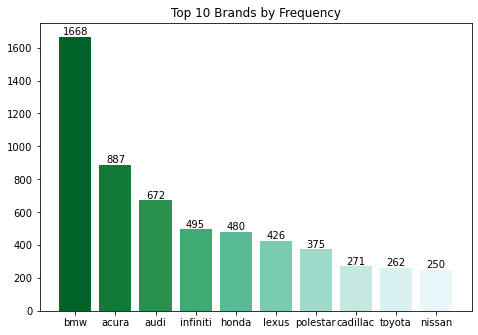

In [12]:
# bar plot of top 10 brands
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([0,0,1,1])    #  set up plot size and axes
k = ax.bar(top10_brand['Brand'],top10_brand['Count'],color = sns.color_palette('BuGn_r',10))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Top 10 Brands by Frequency')
plt.show()

## 2.2 Attribute popularity counting

### 2.2.1 Tokenization of Reviews and Find & Replace of attribute categories

In [13]:
# import attribute information dataset that is derived by the Yichen and Diwei
attri = pd.read_csv("car attribute.csv")

# displaying some categories and some sub-categories (keywords)
#attri.iloc[[0, 32, 48, 65, 74, 98, 114]] 

In [14]:
# tokenize each word/symbols, and at the same time replace any detected car model name with brand name
tokenized_attr = []
for i in review["comment"]:
    text = word_tokenize(i)
    for j in range(len(text)):
        if any(text[j]==attri['Keyword']):
            Category = attri.loc[attri.Keyword==text[j],'Category'].iloc[0]
            text[j] = Category
    tokenized_attr.append(text)

In [15]:
# append lowercased tokens to a list
attr_mentioned = []
for sent in tokenized_attr:
    attr_post=[]
    for m in range(len(sent)):
        if any(sent[m].lower()==attri['Category']):
            attr_post.append(sent[m].lower())
    if attr_post != []:# only append non-empty lists
        attr_post = remove_duplicate(attr_post)
        attr_mentioned.append(attr_post)
          
attr_mentioned

[['interior', 'performance'],
 ['purchase', 'performance', 'comfort', 'safety', 'car parts'],
 ['performance', 'purchase'],
 ['type', 'purchase', 'interior'],
 ['performance', 'type', 'purchase'],
 ['interior'],
 ['performance'],
 ['performance'],
 ['type'],
 ['type', 'car parts'],
 ['purchase', 'car parts'],
 ['performance'],
 ['comfort', 'purchase'],
 ['purchase', 'comfort'],
 ['performance'],
 ['performance', 'car parts', 'comfort', 'interior'],
 ['interior', 'comfort'],
 ['interior', 'purchase', 'performance'],
 ['interior'],
 ['interior', 'comfort'],
 ['comfort', 'interior'],
 ['purchase', 'performance'],
 ['comfort'],
 ['comfort'],
 ['comfort'],
 ['performance', 'comfort', 'interior', 'car parts'],
 ['purchase', 'performance', 'car parts'],
 ['car parts', 'interior', 'performance', 'comfort', 'safety'],
 ['performance', 'comfort', 'interior'],
 ['performance', 'safety', 'comfort', 'car parts'],
 ['performance'],
 ['performance'],
 ['performance'],
 ['comfort'],
 ['performance', '

In [16]:
# count attribute mentionings
attrs =  attri['Category'].unique()
attr_count_dict = {}
for i in attrs:
    count = 0
    for j in attr_mentioned:
        if i in j:
            count +=1
    attr_count_dict[i] = count

In [17]:
# sort the counts, display the popularity of attributes
attr_count_df = pd.DataFrame(list(attr_count_dict.items()),columns = ['Attribute Catgory','Count'])
attr_count_df.sort_values(by=["Count"], ascending = False, ignore_index = True) 

,Attribute Catgory,Count
0,performance,1735
1,purchase,1567
2,type,1087
3,car parts,678
4,comfort,546
5,interior,539
6,safety,370


## 2.3 Match brand mentionings and attribute mentionings

The result table of this part will help us visualize which car attribute(s) the users care the most when comparing certain brands

### 2.3.1 Get mentionings of brands and attributes without dropping empty lists
We hope to one-on-one match brand mentionings and attribute mentionings of each post, then drop the posts mentioned neither brand nor attribute. So, we first keep the empty lists to make sure the rows(indexes) of brand and attribute mentionings match with each other.

In [18]:
brand_mentioned_with_empty = []
for sent in tokenized_brand:
    brand_post = []
    for m in range(len(sent)):
        if any(sent[m].lower()==car['Brand']):
            brand_post.append(sent[m].lower())
        brand_post = remove_duplicate(brand_post)
    brand_mentioned_with_empty.append(brand_post)  # append both empty and non-empty lists

brand_mentioned_with_empty

[['bmw', 'chevrolet', 'porsche', 'cadillac'],
 ['polestar'],
 ['cadillac', 'toyota', 'saturn'],
 [],
 ['cadillac', 'audi', 'bmw'],
 [],
 [],
 ['cadillac', 'bmw', 'mercedes', 'audi'],
 [],
 ['bmw', 'chevrolet', 'dodge', 'cadillac', 'gmc', 'ford'],
 [],
 ['chevrolet', 'dodge', 'lexus', 'infiniti', 'bmw', 'audi'],
 ['ford', 'volvo'],
 [],
 ['cadillac', 'lexus', 'bmw'],
 ['bmw'],
 ['bmw'],
 [],
 [],
 [],
 [],
 ['honda', 'toyota', 'bmw'],
 ['chevrolet'],
 ['toyota', 'honda'],
 [],
 [],
 [],
 [],
 [],
 ['cadillac'],
 [],
 [],
 ['cadillac', 'lincoln'],
 [],
 ['lincoln', 'cadillac', 'bmw', 'ford', 'honda'],
 ['cadillac'],
 ['cadillac'],
 ['cadillac', 'bmw', 'polestar', 'audi', 'infiniti'],
 [],
 ['dodge', 'bmw', 'cadillac'],
 ['audi', 'lexus', 'cadillac'],
 [],
 ['cadillac', 'bmw', 'chrysler', 'infiniti'],
 [],
 ['mercedes', 'bmw', 'audi', 'lexus', 'cadillac', 'infiniti', 'acura'],
 [],
 [],
 ['cadillac', 'bmw'],
 [],
 ['audi', 'bmw', 'cadillac'],
 ['bmw', 'chrysler', 'cadillac', 'acura', 'mer

In [19]:
attr_mentioned_with_empty = []
for sent in tokenized_attr:
    attr_post = []
    for m in range(len(sent)):
        if any(sent[m].lower()==attri['Category']):
            attr_post.append(sent[m].lower())
        attr_post = remove_duplicate(attr_post)
    attr_mentioned_with_empty.append(attr_post)  # append both empty and non-empty lists

attr_mentioned_with_empty

[[],
 [],
 ['interior', 'performance'],
 [],
 ['purchase', 'performance', 'comfort', 'safety', 'car parts'],
 [],
 [],
 ['performance', 'purchase'],
 [],
 ['type', 'purchase', 'interior'],
 ['performance', 'type', 'purchase'],
 ['interior'],
 ['performance'],
 [],
 ['performance'],
 ['type'],
 ['type', 'car parts'],
 [],
 [],
 [],
 [],
 [],
 ['purchase', 'car parts'],
 [],
 [],
 ['performance'],
 ['comfort', 'purchase'],
 ['purchase', 'comfort'],
 [],
 ['performance'],
 [],
 [],
 [],
 [],
 ['performance', 'car parts', 'comfort', 'interior'],
 [],
 ['interior', 'comfort'],
 ['interior', 'purchase', 'performance'],
 ['interior'],
 ['interior', 'comfort'],
 ['comfort', 'interior'],
 [],
 ['purchase', 'performance'],
 [],
 ['comfort'],
 [],
 ['comfort'],
 [],
 ['comfort'],
 ['performance', 'comfort', 'interior', 'car parts'],
 ['purchase', 'performance', 'car parts'],
 [],
 ['car parts', 'interior', 'performance', 'comfort', 'safety'],
 ['performance', 'comfort', 'interior'],
 ['performanc

In [20]:
len(brand_mentioned_with_empty) == len(attr_mentioned_with_empty)
# good! the numbers of rows matched. Now we can merge the two lists into one dataframe, and drop rows that contain empty lists

True

### 2.3.2 Merge brand and attribute mentionings and drop NA

In [21]:
#putting brand names and attributes together
data = []
df_brand_attri = pd.DataFrame(data)

In [22]:
brand_mentioned = pd.Series(brand_mentioned_with_empty)
attri_mentioned = pd.Series(attr_mentioned_with_empty)
df_brand_attri.insert(loc = 0,column='Brand_Mentioned', value=brand_mentioned)
df_brand_attri.insert(loc = 1, column='Attribute_Mentioned', value=attri_mentioned)
df_brand_attri

,Brand_Mentioned,Attribute_Mentioned
0,"[bmw, chevrolet, porsche, cadillac]",[]
1,[polestar],[]
2,"[cadillac, toyota, saturn]","[interior, performance]"
3,[],[]
4,"[cadillac, audi, bmw]","[purchase, performance, comfort, safety, car p..."
...,...,...
5495,[],[comfort]
5496,[subaru],[]
5497,[],[comfort]
5498,[honda],[]


In [23]:
import numpy as np
df_brand_attri.Brand_Mentioned = df_brand_attri.Brand_Mentioned.apply(lambda Brand_Mentioned: np.nan if len(Brand_Mentioned)==0 
                                                                      else Brand_Mentioned)
df_brand_attri.Attribute_Mentioned = df_brand_attri.Attribute_Mentioned.apply(lambda Attribute_Mentioned: np.nan if len(Attribute_Mentioned)==0 
                                                                      else Attribute_Mentioned)
df_brand_attri

,Brand_Mentioned,Attribute_Mentioned
0,"[bmw, chevrolet, porsche, cadillac]",NaN
1,[polestar],NaN
2,"[cadillac, toyota, saturn]","[interior, performance]"
3,NaN,NaN
4,"[cadillac, audi, bmw]","[purchase, performance, comfort, safety, car p..."
...,...,...
5495,NaN,[comfort]
5496,[subaru],NaN
5497,NaN,[comfort]
5498,[honda],NaN


In [24]:
# exclude posts that mentioned neither attributs nor brand names
df_brand_attri = df_brand_attri[df_brand_attri['Brand_Mentioned'].notna()]
df_brand_attri = df_brand_attri[df_brand_attri['Attribute_Mentioned'].notna()]
df_brand_attri

,Brand_Mentioned,Attribute_Mentioned
2,"[cadillac, toyota, saturn]","[interior, performance]"
4,"[cadillac, audi, bmw]","[purchase, performance, comfort, safety, car p..."
7,"[cadillac, bmw, mercedes, audi]","[performance, purchase]"
9,"[bmw, chevrolet, dodge, cadillac, gmc, ford]","[type, purchase, interior]"
11,"[chevrolet, dodge, lexus, infiniti, bmw, audi]",[interior]
...,...,...
5482,[toyota],"[comfort, type]"
5484,[bmw],[purchase]
5486,[toyota],[type]
5491,"[honda, lexus]",[comfort]


In [25]:
#only keeps top 10 brand and top 5 attributes
top_brand = ["bmw","acura","audi","infiniti","honda","lexus",
             "polestar","cadillac","toyota","nissan"]
top_attri = ["performance","purchase","type","car parts","comfort"]

for brand in df_brand_attri.Brand_Mentioned:
    for i in brand:
        if i not in top_brand:
            brand.remove(i)
        
for attri in df_brand_attri.Attribute_Mentioned:
    for i in attri:
        if i not in top_attri:
            attri.remove(i)
        
df_brand_attri
    

,Brand_Mentioned,Attribute_Mentioned
2,"[cadillac, toyota]",[performance]
4,"[cadillac, audi, bmw]","[purchase, performance, comfort, car parts]"
7,"[cadillac, bmw, audi]","[performance, purchase]"
9,"[bmw, dodge, cadillac, ford]","[type, purchase]"
11,"[dodge, lexus, infiniti, bmw, audi]",[]
...,...,...
5482,[toyota],"[comfort, type]"
5484,[bmw],[purchase]
5486,[toyota],[type]
5491,"[honda, lexus]",[comfort]


In [26]:
#remove nan
df_brand_attri.Brand_Mentioned = df_brand_attri.Brand_Mentioned.apply(lambda Brand_Mentioned: np.nan if len(Brand_Mentioned)==0 
                                                                      else Brand_Mentioned)
df_brand_attri.Attribute_Mentioned = df_brand_attri.Attribute_Mentioned.apply(lambda Attribute_Mentioned: np.nan if len(Attribute_Mentioned)==0 
                                                                      else Attribute_Mentioned)

df_brand_attri = df_brand_attri[df_brand_attri['Brand_Mentioned'].notna()]
df_brand_attri = df_brand_attri[df_brand_attri['Attribute_Mentioned'].notna()]

df_brand_attri

,Brand_Mentioned,Attribute_Mentioned
2,"[cadillac, toyota]",[performance]
4,"[cadillac, audi, bmw]","[purchase, performance, comfort, car parts]"
7,"[cadillac, bmw, audi]","[performance, purchase]"
9,"[bmw, dodge, cadillac, ford]","[type, purchase]"
12,[volvo],[performance]
...,...,...
5482,[toyota],"[comfort, type]"
5484,[bmw],[purchase]
5486,[toyota],[type]
5491,"[honda, lexus]",[comfort]


In [27]:
#import os  
#os.makedirs('C:/YICHEN WANG/Course/2022 WINTER/INSY 669/ASSIGNMENT/assignment1', exist_ok=True)  
#df_brand_attri.to_csv('C:/YICHEN WANG/Course/2022 WINTER/INSY 669/ASSIGNMENT/assignment1/df_brand_attri.csv')  

In [28]:
# pip install afinn

In [29]:
data = []
df_sentiment = pd.DataFrame(data)
df_sentiment["comment"] = review["comment"].copy()
from afinn import Afinn
afn = Afinn()

Sentiment_score = [afn.score(text) for text in df_sentiment["comment"]]
df_sentiment['Sentiment score'] = Sentiment_score

In [30]:
df_sentiment["Brand_Mentioned"] = df_brand_attri["Brand_Mentioned"]
df_sentiment["Attribute_Mentioned"] = df_brand_attri["Attribute_Mentioned"]

In [31]:
df_sentiment1 = df_sentiment.drop(columns = ["comment"])

In [32]:
df_sentiment1

,Sentiment score,Brand_Mentioned,Attribute_Mentioned
0,12.0,NaN,NaN
1,14.0,NaN,NaN
2,10.0,"[cadillac, toyota]",[performance]
3,0.0,NaN,NaN
4,18.0,"[cadillac, audi, bmw]","[purchase, performance, comfort, car parts]"
...,...,...,...
5495,7.0,NaN,NaN
5496,15.0,NaN,NaN
5497,1.0,NaN,NaN
5498,2.0,NaN,NaN


In [33]:
#drop null
df_sentiment1 = df_sentiment1[df_sentiment1['Brand_Mentioned'].notna()]
df_sentiment1 = df_sentiment1[df_sentiment1['Attribute_Mentioned'].notna()]

In [34]:
df_sentiment2 = df_sentiment1.copy().reset_index()
df_sentiment2

,index,Sentiment score,Brand_Mentioned,Attribute_Mentioned
0,2,10.0,"[cadillac, toyota]",[performance]
1,4,18.0,"[cadillac, audi, bmw]","[purchase, performance, comfort, car parts]"
2,7,19.0,"[cadillac, bmw, audi]","[performance, purchase]"
3,9,3.0,"[bmw, dodge, cadillac, ford]","[type, purchase]"
4,12,-6.0,[volvo],[performance]
...,...,...,...,...
2262,5482,4.0,[toyota],"[comfort, type]"
2263,5484,2.0,[bmw],[purchase]
2264,5486,2.0,[toyota],[type]
2265,5491,5.0,"[honda, lexus]",[comfort]


In [35]:
for j in top_brand:
    temp_brand = []
    for i in df_sentiment2["Brand_Mentioned"]:
        if j in i:
            temp_brand.append(1)
        else:
            temp_brand.append(0)
    temp_brand = pd.Series(temp_brand)
    df_sentiment2[j] = temp_brand

for j in top_attri:
    temp_attri = []
    for i in df_sentiment2["Attribute_Mentioned"]:
        if j in i:
            temp_attri.append(1)
        else:
            temp_attri.append(0)
    temp_attri = pd.Series(temp_attri)
    df_sentiment2[j] = temp_attri

In [36]:
df_sentiment2

,index,Sentiment score,Brand_Mentioned,Attribute_Mentioned,bmw,acura,audi,infiniti,honda,lexus,polestar,cadillac,toyota,nissan,performance,purchase,type,car parts,comfort
0,2,10.0,"[cadillac, toyota]",[performance],0,0,0,0,0,0,0,1,1,0,1,0,0,0,0
1,4,18.0,"[cadillac, audi, bmw]","[purchase, performance, comfort, car parts]",1,0,1,0,0,0,0,1,0,0,1,1,0,1,1
2,7,19.0,"[cadillac, bmw, audi]","[performance, purchase]",1,0,1,0,0,0,0,1,0,0,1,1,0,0,0
3,9,3.0,"[bmw, dodge, cadillac, ford]","[type, purchase]",1,0,0,0,0,0,0,1,0,0,0,1,1,0,0
4,12,-6.0,[volvo],[performance],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,5482,4.0,[toyota],"[comfort, type]",0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
2263,5484,2.0,[bmw],[purchase],1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2264,5486,2.0,[toyota],[type],0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2265,5491,5.0,"[honda, lexus]",[comfort],0,0,0,0,1,1,0,0,0,0,0,0,0,0,1


## 2.4 Calculate Average Sentiment Score for brands and attributes

In [37]:
import pandas as pd
#sentiment  = pd.read_csv('/Users/ziyezhang/Downloads/sentiment.csv')
sentiment = df_sentiment2.copy()
sentiment = sentiment.drop(['index', 'Brand_Mentioned','Attribute_Mentioned'],axis=1)


In [38]:
sent_score_dict = {}
for i in sentiment.columns[1:]:
    mean_score = sentiment[sentiment[i]==1].loc[:,'Sentiment score'].mean()
    sent_score_dict[i]=mean_score
Avg_sentiment_score = pd.DataFrame(sent_score_dict,index=[0]).T
Avg_sentiment_score.columns=['Average Sentiment Score']

In [39]:
sent_score_df = Avg_sentiment_score.sort_values(by='Average Sentiment Score',ascending=False)
attr_list = ['comfort','type','car parts', 'purchase', 'performance']
attributes = sent_score_df.loc[attr_list]
brand_list = [ 'audi', 'cadillac', 'lexus', 'toyota', 'honda', 'infiniti',
              'polestar','acura','nissan','bmw']
brands = sent_score_df.loc[brand_list]

In [40]:
brands

,Average Sentiment Score
audi,11.357553
cadillac,10.908654
lexus,10.085174
toyota,9.835000
honda,9.644022
infiniti,9.546154
polestar,9.475248
acura,9.118936
nissan,8.790576
bmw,8.590945


In [41]:
attributes

,Average Sentiment Score
comfort,11.712195
type,9.351479
car parts,9.166348
purchase,9.094068
performance,8.780660


### 2.4.1 Regression Analysis of Sentiment Score

In [42]:
import statsmodels.api as sm
y = sentiment['Sentiment score']
X = sm.add_constant(sentiment.drop(['Sentiment score'],axis=1))
mod = sm.OLS(endog = y , exog = X )
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        Sentiment score   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     36.87
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           4.12e-96
Time:                        22:08:29   Log-Likelihood:                -8160.1
No. Observations:                2267   AIC:                         1.635e+04
Df Residuals:                    2251   BIC:                         1.644e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.8714      0.479     -3.908      

D:\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# 3. Lift Calculation

## 3.1 Calculate Brand-Brand Lift & Dissimilarity

In [43]:
brand_lift_array = np.empty((len(top10_brand),len(top10_brand)))
brand_lift_array[:] = np.NaN

In [44]:
N = len(review) # total number of reviews
N

5500

In [45]:
N = len(review)
for i in range(len(top10_brand)): 
    brand1 = top10_brand['Brand'][i]
    brand1_count =  top10_brand['Count'][i] # number of reviews containing brand 1
    
    for j in range(i+1, len(top10_brand)):
        brand2 = top10_brand['Brand'][j]
        brand2_count = top10_brand['Count'][j] # number of reviews containing brand 2
        
        brand1_2_count = 0 # number of reviews containing both brand 1 and 2
        for brands in brand_mentioned:
            if brand1 in brands and brand2 in brands:
                brand1_2_count += 1
                
        brand_lift = N*brand1_2_count/(brand1_count*brand2_count) # calculate lift
        brand_lift_array[i,j] = brand_lift

In [46]:
brand_lift_array

array([[       nan, 1.3159709 , 1.78116435, 1.69864109, 1.20903277,
        1.46291418, 1.7146283 , 1.58176042, 1.20819375, 1.02877698],
       [       nan,        nan, 2.26066328, 2.35500438, 3.1649286 ,
        2.06689215, 1.63697858, 1.55588929, 1.32533542, 1.41375423],
       [       nan,        nan,        nan, 2.3478836 , 1.70510913,
        2.47841214, 1.70238095, 2.89931471, 1.53069338, 1.21130952],
       [       nan,        nan,        nan,        nan, 1.55092593,
        3.26030256, 1.74814815, 2.29602296, 1.78117048, 3.28888889],
       [       nan,        nan,        nan,        nan,        nan,
        1.88282473, 2.13888889, 1.3952952 , 3.54246183, 2.2       ],
       [       nan,        nan,        nan,        nan,        nan,
               nan, 1.27386541, 2.52499004, 4.68139627, 1.96244131],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan, 1.51537515, 1.11959288, 1.17333333],
       [       nan,        nan,        na

In [47]:
brand_dissimi_array = 1/brand_lift_array # calculate dissimilarity for MDS plot
#np.fill_diagonal(dissimi_array, 0) # dissimilarity between a brand and itself is 0
np.nan_to_num(brand_dissimi_array, copy=False, nan=0.0)
brand_dissimi_array = brand_dissimi_array + brand_dissimi_array.T  # fill the lower triangular part
brand_dissimi_array

array([[0.        , 0.75989522, 0.5614305 , 0.58870588, 0.82710744,
        0.6835671 , 0.58321678, 0.63220699, 0.82768182, 0.97202797],
       [0.75989522, 0.        , 0.44234805, 0.42462766, 0.31596289,
        0.48381818, 0.61088154, 0.64271925, 0.75452597, 0.70733652],
       [0.5614305 , 0.44234805, 0.        , 0.42591549, 0.58647273,
        0.40348414, 0.58741259, 0.34490909, 0.6532987 , 0.82555283],
       [0.58870588, 0.42462766, 0.42591549, 0.        , 0.64477612,
        0.30672   , 0.5720339 , 0.43553571, 0.56142857, 0.30405405],
       [0.82710744, 0.31596289, 0.58647273, 0.64477612, 0.        ,
        0.53111688, 0.46753247, 0.71669421, 0.28228956, 0.45454545],
       [0.6835671 , 0.48381818, 0.40348414, 0.30672   , 0.53111688,
        0.        , 0.78501229, 0.39604117, 0.21361148, 0.50956938],
       [0.58321678, 0.61088154, 0.58741259, 0.5720339 , 0.46753247,
        0.78501229, 0.        , 0.6599026 , 0.89318182, 0.85227273],
       [0.63220699, 0.64271925, 0.3449090

In [48]:
brand_lift_df = pd.DataFrame(data=brand_lift_array, index=top10_brand['Brand'], columns=top10_brand['Brand'])
brand_lift_df

Brand,bmw,acura,audi,infiniti,honda,lexus,polestar,cadillac,toyota,nissan
Brand,,,,,,,,,,
bmw,NaN,1.315971,1.781164,1.698641,1.209033,1.462914,1.714628,1.581760,1.208194,1.028777
acura,NaN,NaN,2.260663,2.355004,3.164929,2.066892,1.636979,1.555889,1.325335,1.413754
audi,NaN,NaN,NaN,2.347884,1.705109,2.478412,1.702381,2.899315,1.530693,1.211310
infiniti,NaN,NaN,NaN,NaN,1.550926,3.260303,1.748148,2.296023,1.781170,3.288889
honda,NaN,NaN,NaN,NaN,NaN,1.882825,2.138889,1.395295,3.542462,2.200000
lexus,NaN,NaN,NaN,NaN,NaN,NaN,1.273865,2.524990,4.681396,1.962441
polestar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.515375,1.119593,1.173333
cadillac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.936565,1.217712
toyota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.114504


<AxesSubplot:title={'center':'Heatmap of Brand-Brand Lift'}, xlabel='Brand', ylabel='Brand'>

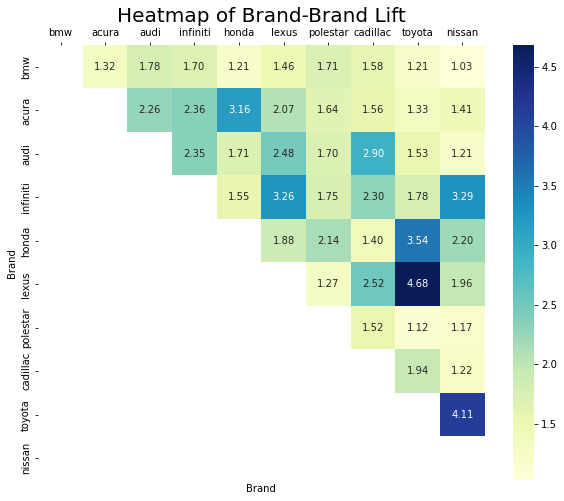

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,8))
plt.title('Heatmap of Brand-Brand Lift', fontsize = 20)
ax.xaxis.tick_top()
sns.heatmap(brand_lift_df, cmap = "YlGnBu", annot = True, fmt='.2f')

In [50]:
brand_dissimi_df = pd.DataFrame(data=brand_dissimi_array, index=top10_brand['Brand'], columns=top10_brand['Brand'])
brand_dissimi_df

Brand,bmw,acura,audi,infiniti,honda,lexus,polestar,cadillac,toyota,nissan
Brand,,,,,,,,,,
bmw,0.000000,0.759895,0.561431,0.588706,0.827107,0.683567,0.583217,0.632207,0.827682,0.972028
acura,0.759895,0.000000,0.442348,0.424628,0.315963,0.483818,0.610882,0.642719,0.754526,0.707337
audi,0.561431,0.442348,0.000000,0.425915,0.586473,0.403484,0.587413,0.344909,0.653299,0.825553
infiniti,0.588706,0.424628,0.425915,0.000000,0.644776,0.306720,0.572034,0.435536,0.561429,0.304054
honda,0.827107,0.315963,0.586473,0.644776,0.000000,0.531117,0.467532,0.716694,0.282290,0.454545
lexus,0.683567,0.483818,0.403484,0.306720,0.531117,0.000000,0.785012,0.396041,0.213611,0.509569
polestar,0.583217,0.610882,0.587413,0.572034,0.467532,0.785012,0.000000,0.659903,0.893182,0.852273
cadillac,0.632207,0.642719,0.344909,0.435536,0.716694,0.396041,0.659903,0.000000,0.516378,0.821212
toyota,0.827682,0.754526,0.653299,0.561429,0.282290,0.213611,0.893182,0.516378,0.000000,0.243043


<AxesSubplot:title={'center':'Heatmap of Brand-Brand Dissimilarity'}, xlabel='Brand', ylabel='Brand'>

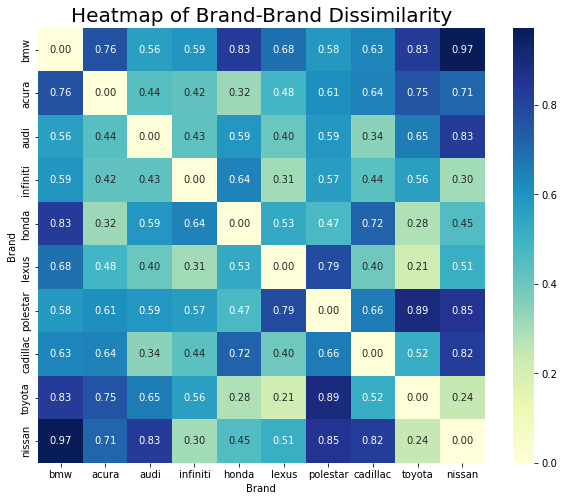

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,8))
plt.title('Heatmap of Brand-Brand Dissimilarity', fontsize = 20)
sns.heatmap(brand_dissimi_df, cmap = "YlGnBu", annot = True, fmt='.2f')

## 3.2 Calculate Brand-Attribute Lift & Dissimilarity

In [52]:
attr_count_df = attr_count_df.sort_values(by=["Count"], ascending = False, ignore_index = True)
attr_count_df

,Attribute Catgory,Count
0,performance,1735
1,purchase,1567
2,type,1087
3,car parts,678
4,comfort,546
5,interior,539
6,safety,370


In [53]:
top5_attr = attr_count_df.head(5)
top5_attr # the 5 most frequently mentioned attributes

,Attribute Catgory,Count
0,performance,1735
1,purchase,1567
2,type,1087
3,car parts,678
4,comfort,546


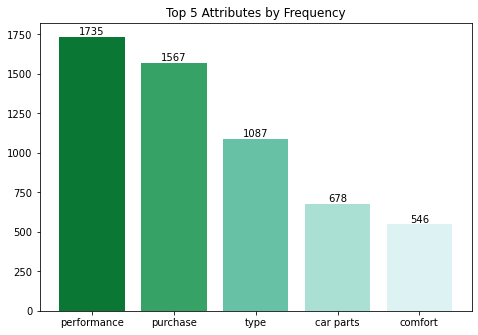

In [54]:
# create a new attributes counts dataframe for plotting
attributes = ["performance","purchase","type","car parts","comfort"]
attributes = pd.DataFrame(attributes,columns=['attributes'])
attri_count = [1735,1567,1087,678,546]
attri_count = pd.DataFrame(attri_count,columns=['counts'])
attri = pd.concat([attributes,attri_count],axis=1)

# bar plot of attributes popuparity
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([0,0,1,1])    #  set up plot size and axes
k = ax.bar(attri['attributes'],attri['counts'],color = sns.color_palette('BuGn_r',5))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Top 5 Attributes by Frequency')
plt.show()

In [55]:
brand_count_df = brand_count_df.sort_values(by=["Count"], ascending = False, ignore_index = True)
brand_count_df

,Brand,Count
0,bmw,1668
1,acura,887
2,audi,672
3,infiniti,495
4,honda,480
5,lexus,426
6,polestar,375
7,cadillac,271
8,toyota,262
9,nissan,250


In [56]:
top5_brand = brand_count_df.head(5)
top5_brand # pick the 5 most frequently mentioned brands

,Brand,Count
0,bmw,1668
1,acura,887
2,audi,672
3,infiniti,495
4,honda,480


In [57]:
df_brand_attri

,Brand_Mentioned,Attribute_Mentioned
2,"[cadillac, toyota]",[performance]
4,"[cadillac, audi, bmw]","[purchase, performance, comfort, car parts]"
7,"[cadillac, bmw, audi]","[performance, purchase]"
9,"[bmw, dodge, cadillac, ford]","[type, purchase]"
12,[volvo],[performance]
...,...,...
5482,[toyota],"[comfort, type]"
5484,[bmw],[purchase]
5486,[toyota],[type]
5491,"[honda, lexus]",[comfort]


In [58]:
top5_brand_attri = pd.concat([top5_brand.rename(columns={'Brand':'Word'}), 
                                    top5_attr.rename(columns={'Attribute Catgory':'Word'})], 
                                   ignore_index=True)
top5_brand_attri

,Word,Count
0,bmw,1668
1,acura,887
2,audi,672
3,infiniti,495
4,honda,480
5,performance,1735
6,purchase,1567
7,type,1087
8,car parts,678
9,comfort,546


In [59]:
df_brand_attri['Merge'] = df_brand_attri['Brand_Mentioned'] + df_brand_attri['Attribute_Mentioned']
df_brand_attri

,Brand_Mentioned,Attribute_Mentioned,Merge
2,"[cadillac, toyota]",[performance],"[cadillac, toyota, performance]"
4,"[cadillac, audi, bmw]","[purchase, performance, comfort, car parts]","[cadillac, audi, bmw, purchase, performance, c..."
7,"[cadillac, bmw, audi]","[performance, purchase]","[cadillac, bmw, audi, performance, purchase]"
9,"[bmw, dodge, cadillac, ford]","[type, purchase]","[bmw, dodge, cadillac, ford, type, purchase]"
12,[volvo],[performance],"[volvo, performance]"
...,...,...,...
5482,[toyota],"[comfort, type]","[toyota, comfort, type]"
5484,[bmw],[purchase],"[bmw, purchase]"
5486,[toyota],[type],"[toyota, type]"
5491,"[honda, lexus]",[comfort],"[honda, lexus, comfort]"


In [60]:
brand_attr_lift_array = np.empty((len(top5_brand_attri),len(top5_brand_attri)))
brand_attr_lift_array[:] = np.NaN

In [61]:
N = len(review) # total number of reviews
N

5500

In [62]:
for i in range(len(top5_brand_attri)): 
    word1 = top5_brand_attri['Word'][i]
    word1_count =  top5_brand_attri['Count'][i] # number of reviews containing word 1
    
    for j in range(i+1, len(top5_brand_attri)):
        word2 = top5_brand_attri['Word'][j]
        word2_count = top5_brand_attri['Count'][j] # number of reviews containing word 2
        
        word1_2_count = 0 # number of reviews containing both word 1 and 2
        for words in df_brand_attri['Merge']:
            if word1 in words and word2 in words:
                word1_2_count += 1
                
        brand_attr_lift = N*word1_2_count/(word1_count*word2_count) # calculate lift
        brand_attr_lift_array[i,j] = brand_attr_lift

In [63]:
brand_attr_lift_array

array([[       nan, 1.1300993 , 1.49166381, 1.43884892, 1.05103417,
        1.38546224, 1.50664408, 1.41055509, 1.52223354, 1.41315519],
       [       nan,        nan, 1.87312101, 1.97920581, 2.48027057,
        1.38666424, 1.35726357, 1.70561385, 1.61876066, 1.29464673],
       [       nan,        nan,        nan, 1.98412698, 1.55164931,
        1.50010292, 1.59825417, 1.67906974, 1.61759025, 1.94869615],
       [       nan,        nan,        nan,        nan, 1.41203704,
        1.47934678, 1.65922144, 1.65593376, 1.70435923, 1.26170126],
       [       nan,        nan,        nan,        nan,        nan,
        1.4595341 , 1.47707934, 1.67605796, 1.72382006, 1.59493284],
       [       nan,        nan,        nan,        nan,        nan,
               nan, 1.1713125 , 1.37649825, 1.45877432, 1.45728431],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan, 1.2044062 , 1.25796997, 1.30495966],
       [       nan,        nan,        na

In [64]:
brand_attr_dissimi_array = 1/brand_attr_lift_array # calculate dissimilarity for MDS plot
np.nan_to_num(brand_attr_dissimi_array, copy=False, nan=0.0)
brand_attr_dissimi_array = brand_attr_dissimi_array + brand_attr_dissimi_array.T  # fill the lower triangular part
brand_attr_dissimi_array

array([[0.        , 0.88487799, 0.67039234, 0.695     , 0.95144385,
        0.72178077, 0.66372676, 0.70894076, 0.65692942, 0.70763636],
       [0.88487799, 0.        , 0.53386834, 0.50525316, 0.40318182,
        0.72115511, 0.73677657, 0.58629918, 0.61775655, 0.77241148],
       [0.67039234, 0.53386834, 0.        , 0.504     , 0.64447552,
        0.66662093, 0.62568271, 0.59556788, 0.61820353, 0.51316364],
       [0.695     , 0.50525316, 0.504     , 0.        , 0.70819672,
        0.67597403, 0.60269231, 0.60388889, 0.58673077, 0.79258065],
       [0.95144385, 0.40318182, 0.64447552, 0.70819672, 0.        ,
        0.68515014, 0.6770117 , 0.59663808, 0.58010695, 0.62698565],
       [0.72178077, 0.72115511, 0.66662093, 0.67597403, 0.68515014,
        0.        , 0.85374313, 0.72648112, 0.68550699, 0.6862079 ],
       [0.66372676, 0.73677657, 0.62568271, 0.60269231, 0.6770117 ,
        0.85374313, 0.        , 0.83028467, 0.79493154, 0.76630721],
       [0.70894076, 0.58629918, 0.5955678

In [65]:
brand_attr_lift_df = pd.DataFrame(data=brand_attr_lift_array, 
                                  index=top5_brand_attri['Word'], columns=top5_brand_attri['Word'])
brand_attr_lift_df

Word,bmw,acura,audi,infiniti,honda,performance,purchase,type,car parts,comfort
Word,,,,,,,,,,
bmw,NaN,1.130099,1.491664,1.438849,1.051034,1.385462,1.506644,1.410555,1.522234,1.413155
acura,NaN,NaN,1.873121,1.979206,2.480271,1.386664,1.357264,1.705614,1.618761,1.294647
audi,NaN,NaN,NaN,1.984127,1.551649,1.500103,1.598254,1.679070,1.617590,1.948696
infiniti,NaN,NaN,NaN,NaN,1.412037,1.479347,1.659221,1.655934,1.704359,1.261701
honda,NaN,NaN,NaN,NaN,NaN,1.459534,1.477079,1.676058,1.723820,1.594933
performance,NaN,NaN,NaN,NaN,NaN,NaN,1.171312,1.376498,1.458774,1.457284
purchase,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.204406,1.257970,1.304960
type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.888096,1.390054
car parts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.005738


<AxesSubplot:title={'center':'Heatmap of Brand-Attribute Lift'}, xlabel='Word', ylabel='Word'>

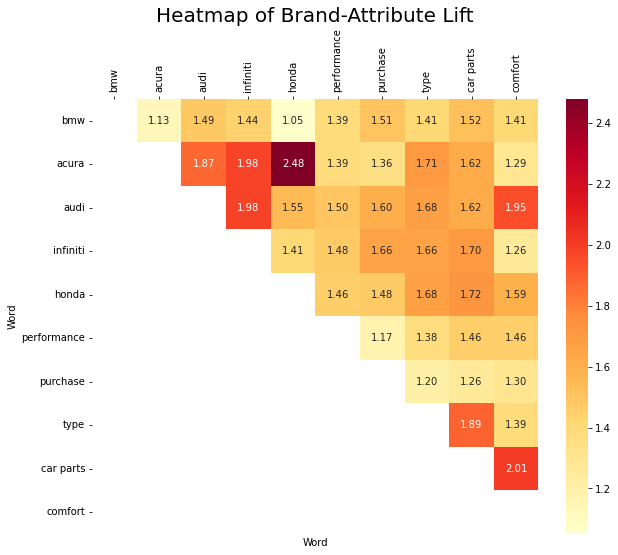

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,8))
plt.title('Heatmap of Brand-Attribute Lift', fontsize = 20)
ax.xaxis.tick_top()
sns.heatmap(brand_attr_lift_df, cmap = 'YlOrRd', annot = True, fmt='.2f')

In [67]:
brand_attr_dissimi_df = pd.DataFrame(data=brand_attr_dissimi_array, 
                                     index=top5_brand_attri['Word'], columns=top5_brand_attri['Word'])
brand_attr_dissimi_df

Word,bmw,acura,audi,infiniti,honda,performance,purchase,type,car parts,comfort
Word,,,,,,,,,,
bmw,0.000000,0.884878,0.670392,0.695000,0.951444,0.721781,0.663727,0.708941,0.656929,0.707636
acura,0.884878,0.000000,0.533868,0.505253,0.403182,0.721155,0.736777,0.586299,0.617757,0.772411
audi,0.670392,0.533868,0.000000,0.504000,0.644476,0.666621,0.625683,0.595568,0.618204,0.513164
infiniti,0.695000,0.505253,0.504000,0.000000,0.708197,0.675974,0.602692,0.603889,0.586731,0.792581
honda,0.951444,0.403182,0.644476,0.708197,0.000000,0.685150,0.677012,0.596638,0.580107,0.626986
performance,0.721781,0.721155,0.666621,0.675974,0.685150,0.000000,0.853743,0.726481,0.685507,0.686208
purchase,0.663727,0.736777,0.625683,0.602692,0.677012,0.853743,0.000000,0.830285,0.794932,0.766307
type,0.708941,0.586299,0.595568,0.603889,0.596638,0.726481,0.830285,0.000000,0.529634,0.719396
car parts,0.656929,0.617757,0.618204,0.586731,0.580107,0.685507,0.794932,0.529634,0.000000,0.498570


<AxesSubplot:title={'center':'Heatmap of Brand-Attribute Dissimilarity'}, xlabel='Word', ylabel='Word'>

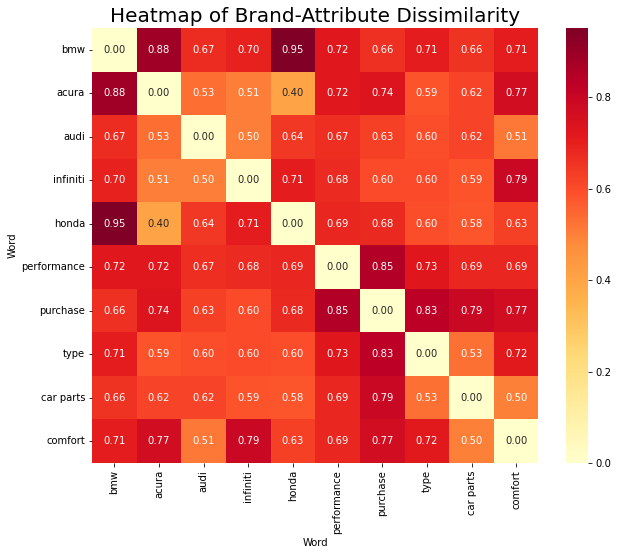

In [68]:
fig, ax = plt.subplots(figsize=(10,8))
plt.title('Heatmap of Brand-Attribute Dissimilarity', fontsize = 20)
sns.heatmap(brand_attr_dissimi_df, cmap = 'YlOrRd', annot = True, fmt='.2f')

# 4. Visualization

## 4.1 Brand-Brand MDS Map Visualization

In [69]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# fit our dissimilarity data frame into MDS
mds = MDS(2,random_state=0,dissimilarity='precomputed')
coordinates = mds.fit_transform(brand_dissimi_df)

# generate coordinate for plotting
coordinates_df = pd.DataFrame(data=coordinates)

Text(0.5, 1.0, 'Elbow Method for KMeans Clustering with Lift Ratio')

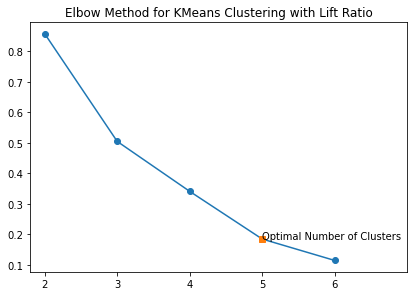

In [70]:
# we want to separate car brands into different communities
# therefore we need to performan unsupervised learning to determine clusters

# we first need to find out the optimal number of clusters via Elbow Method
from sklearn.cluster import KMeans
withinss = []
for i in range(2,7):
    kmeans = KMeans(n_clusters = i)
    cluster = kmeans.fit(coordinates_df)
    labels = cluster.predict(coordinates_df)
    withinss.append(cluster.inertia_)

# plotting out elbow method result
import matplotlib.pyplot as plt
plt.xticks(np.arange(2, 7, 1))
plt.plot([2,3,4,5,6],withinss,'-o')
x0 = [5]
y0 = [withinss[3]]
plt.xlim([1.8, 7])
plt.plot(x0, y0, "s")
plt.annotate("Optimal Number of Clusters", (x0[0], y0[0]))
plt.tight_layout()
plt.title("Elbow Method for KMeans Clustering with Lift Ratio")

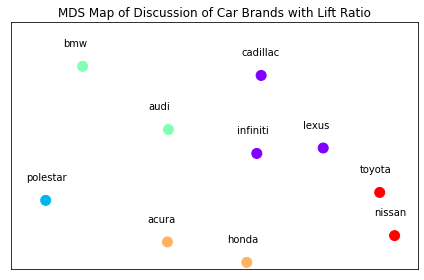

In [71]:
# The optimal number of clusters is 3
# Then we perform K Means clustering with number of clusters = 3
kmeans = KMeans(n_clusters = 5)
cluster = kmeans.fit(coordinates_df)
labels = cluster.predict(coordinates_df)
plt.scatter(coordinates_df.iloc[:,:1],coordinates_df.iloc[:,1:2],c=labels,cmap='rainbow',s=100)

# plotting out the result of clustering

for i in range(len(brand_dissimi_df.columns)):
    x = coordinates[i,0]
    y = coordinates[i,1]
    plt.annotate(brand_dissimi_df.columns[i], xy = (x, y), xytext = (-20, 20),textcoords = 'offset points')
plt.xlim([-0.6, 0.5])    
plt.ylim([-0.4, 0.6]) 

#get current axes
ax = plt.gca()

#hide x-axis
ax.get_xaxis().set_visible(False)

#hide y-axis
ax.get_yaxis().set_visible(False)

plt.title("MDS Map of Discussion of Car Brands with Lift Ratio")

plt.tight_layout()
plt.show()

## 4.2 Brand-Attribute MDS Map Visualization
top 5 brands and top 5 attributes by mentioning frequency

In [72]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# fit our dissimilarity data frame into MDS
mds = MDS(2,random_state=0,dissimilarity='precomputed')
coordinates = mds.fit_transform(brand_attr_dissimi_df)

# generate coordinate for plotting
coordinates_df = pd.DataFrame(data=coordinates)

Text(0.5, 1.0, 'Elbow Method for KMeans Clustering with Lift Ratio')

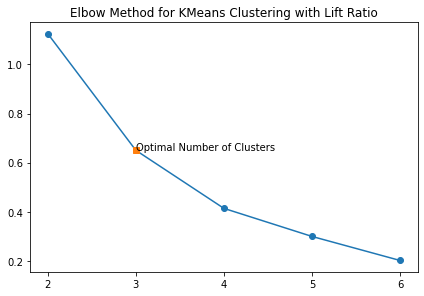

In [73]:
# we want to separate car brands into different communities
# therefore we need to performan unsupervised learning to determine clusters

# we first need to find out the optimal number of clusters via Elbow Method
from sklearn.cluster import KMeans
withinss = []
for i in range(2,7):
    kmeans = KMeans(n_clusters = i)
    cluster = kmeans.fit(coordinates_df)
    labels = cluster.predict(coordinates_df)
    withinss.append(cluster.inertia_)

# plotting out elbow method result
import matplotlib.pyplot as plt
plt.xticks(np.arange(2, 7, 1))
plt.plot([2,3,4,5,6],withinss,'-o')
x0 = [3]
y0 = [withinss[1]]
plt.plot(x0, y0, "s")
plt.annotate("Optimal Number of Clusters", (x0[0], y0[0]))
plt.tight_layout()
plt.title("Elbow Method for KMeans Clustering with Lift Ratio")

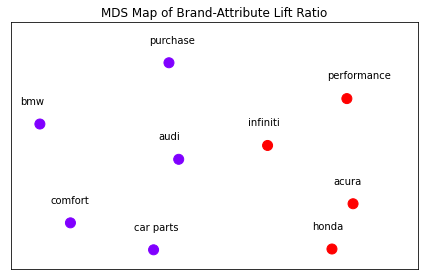

In [74]:
# The optimal number of clusters is 3
# However, after trials we find that cluster number = 2 makes more sense intuitively
# Then we perform K Means clustering with number of clusters = 2
kmeans = KMeans(n_clusters = 2)
cluster = kmeans.fit(coordinates_df)
labels = cluster.predict(coordinates_df)
plt.scatter(coordinates_df.iloc[:,:1],coordinates_df.iloc[:,1:2],c=labels,cmap='rainbow',s=100)

# plotting out the result of clustering

for i in range(len(brand_attr_dissimi_df.columns)):
    x = coordinates[i,0]
    y = coordinates[i,1]
    plt.annotate(brand_attr_dissimi_df.columns[i], xy = (x, y), xytext = (-20, 20),textcoords = 'offset points')
plt.xlim([-0.6, 0.6])    
plt.ylim([-0.4, 0.7]) 

#get current axes
ax = plt.gca()

#hide x-axis
ax.get_xaxis().set_visible(False)

#hide y-axis
ax.get_yaxis().set_visible(False)

plt.title("MDS Map of Brand-Attribute Lift Ratio")

plt.tight_layout()
plt.show()

## 4.3 Average Sentiment Score Plot

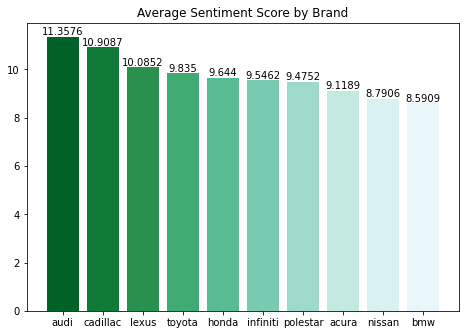

In [75]:
import pandas as pd
x = ['audi','cadillac','lexus','toyota','honda','infiniti','polestar','acura','nissan','bmw']
x = pd.DataFrame(x,columns=['Brands'])
y = [11.3576,10.9087,10.0852,9.8350,9.6440,9.5462,9.4752,9.1189,8.7906,8.5909]
y = pd.DataFrame(y, columns=['Sentiment Score'])
sentiment = pd.concat([x,y],axis=1)

# bar plot
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([0,0,1,1])    #  set up plot size and axes
k = ax.bar(sentiment['Brands'],sentiment['Sentiment Score'],color = sns.color_palette('BuGn_r',10))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Average Sentiment Score by Brand')
plt.show()

## 4.4 Wordcloud

In [76]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

There are 2885607 words in the combination of all review.


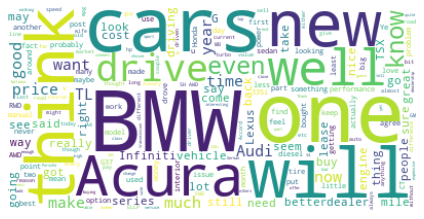

In [77]:
# wordcloud from All reviews
text = " ".join(review for review in review.comment)
print ("There are {} words in the combination of all review.".format(len(text)))
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["car", "preference", "attribute", "brand"])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.show()

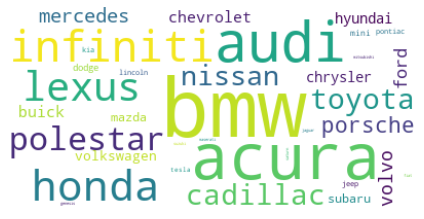

In [78]:
# brand wordcloud

d = {}
for a, x in brand_count_df.values:
    d[a] = x

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()

## 4.5 Brandwise Attribute plotting

In [79]:
import pandas as pd
df = pd.read_csv('df_brand_attri.csv')
df = df.iloc[:,1:]
df

,Brand_Mentioned,Attribute_Mentioned
0,"['cadillac', 'toyota']",['performance']
1,"['cadillac', 'audi', 'bmw']","['purchase', 'performance', 'comfort', 'car pa..."
2,"['cadillac', 'bmw', 'audi']","['performance', 'purchase']"
3,"['bmw', 'cadillac']","['type', 'purchase']"
4,"['cadillac', 'lexus', 'bmw']",['performance']
...,...,...
2222,['toyota'],"['comfort', 'type']"
2223,['bmw'],['purchase']
2224,['toyota'],['type']
2225,"['honda', 'lexus']",['comfort']


In [80]:
for i in range(len(df['Brand_Mentioned'])):
    df['Brand_Mentioned'][i] = df['Brand_Mentioned'][i][1:]
    df['Brand_Mentioned'][i] = df['Brand_Mentioned'][i][:-1]
for i in range(len(df['Attribute_Mentioned'])):
    df['Attribute_Mentioned'][i] = df['Attribute_Mentioned'][i][1:]
    df['Attribute_Mentioned'][i] = df['Attribute_Mentioned'][i][:-1]

In [81]:
# first generate dataframes for each brand
acura = df[df['Brand_Mentioned'].str.contains('acura')]
audi = df[df['Brand_Mentioned'].str.contains('audi')]
bmw = df[df['Brand_Mentioned'].str.contains('bmw')]
cadillac = df[df['Brand_Mentioned'].str.contains('cadillac')]
honda = df[df['Brand_Mentioned'].str.contains('honda')]
infiniti = df[df['Brand_Mentioned'].str.contains('infiniti')]
lexus = df[df['Brand_Mentioned'].str.contains('lexus')]
nissan = df[df['Brand_Mentioned'].str.contains('nissan')]
polestar = df[df['Brand_Mentioned'].str.contains('polestar')]
toyota = df[df['Brand_Mentioned'].str.contains('toyota')]

### bmw
#### 1. Attributes Frequency barchart

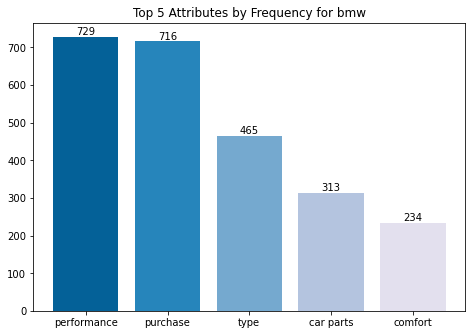

In [82]:
# create bmw dataframe for bar plot
attributes = pd.DataFrame(["performance","purchase","type","car parts","comfort"],columns=['attributes'])
bmw_performance = len(bmw[bmw['Attribute_Mentioned'].str.contains('performance')]['Attribute_Mentioned'])
bmw_purchase = len(bmw[bmw['Attribute_Mentioned'].str.contains('purchase')]['Attribute_Mentioned'])
bmw_type = len(bmw[bmw['Attribute_Mentioned'].str.contains('type')]['Attribute_Mentioned'])
bmw_car_parts = len(bmw[bmw['Attribute_Mentioned'].str.contains('car parts')]['Attribute_Mentioned'])
bmw_comfort = len(bmw[bmw['Attribute_Mentioned'].str.contains('comfort')]['Attribute_Mentioned'])
bmw_attri_count = pd.DataFrame([bmw_performance, bmw_purchase, bmw_type, bmw_car_parts, bmw_comfort],columns=['counts'])
bmw_attri = pd.concat([attributes,bmw_attri_count],axis=1)
bmw_attri['counts']=bmw_attri['counts'].fillna(0)

# bar plot of top 5 attributes for bmw

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([0,0,1,1])    #  set up plot size and axes
k = ax.bar(bmw_attri['attributes'],bmw_attri['counts'],color = sns.color_palette('PuBu_r',5))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Top 5 Attributes by Frequency for bmw')
plt.show()

#### 2. Comparison Brand Frequency Barchart

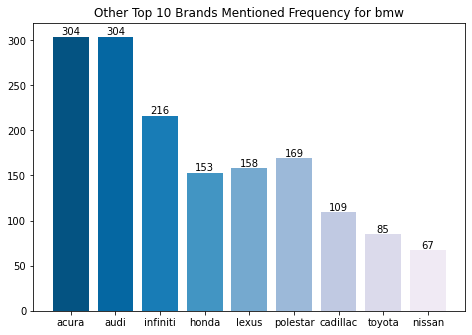

In [84]:
brands = pd.DataFrame(["acura","audi","infiniti","honda","lexus","polestar","cadillac","toyota","nissan"],columns=['brands'])
bmw_acura = len(bmw[bmw['Brand_Mentioned'].str.contains('acura')]['Brand_Mentioned'])
bmw_audi = len(bmw[bmw['Brand_Mentioned'].str.contains('audi')]['Brand_Mentioned'])
bmw_infiniti = len(bmw[bmw['Brand_Mentioned'].str.contains('infiniti')]['Brand_Mentioned'])
bmw_honda = len(bmw[bmw['Brand_Mentioned'].str.contains('honda')]['Brand_Mentioned'])
bmw_lexus = len(bmw[bmw['Brand_Mentioned'].str.contains('lexus')]['Brand_Mentioned'])
bmw_polestar = len(bmw[bmw['Brand_Mentioned'].str.contains('polestar')]['Brand_Mentioned'])
bmw_cadillac = len(bmw[bmw['Brand_Mentioned'].str.contains('cadillac')]['Brand_Mentioned'])
bmw_toyota = len(bmw[bmw['Brand_Mentioned'].str.contains('toyota')]['Brand_Mentioned'])
bmw_nissan = len(bmw[bmw['Brand_Mentioned'].str.contains('nissan')]['Brand_Mentioned'])
bmw_brand_count = pd.DataFrame([bmw_acura,bmw_audi,bmw_infiniti,bmw_honda,bmw_lexus,bmw_polestar,bmw_cadillac,
                                 bmw_toyota,bmw_nissan],columns=['counts'])
bmw_brand = pd.concat([brands,bmw_brand_count],axis=1)
bmw_brand['counts']=bmw_brand['counts'].fillna(0)

# bar plot of other top 10 brands mentioned frequency for bmw

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([0,0,1,1])    #  set up plot size and axes
k = ax.bar(bmw_brand['brands'],bmw_brand['counts'],color = sns.color_palette('PuBu_r',9))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Other Top 10 Brands Mentioned Frequency for bmw')
plt.show()

### acura
#### 1. Attributes Frequency barchart

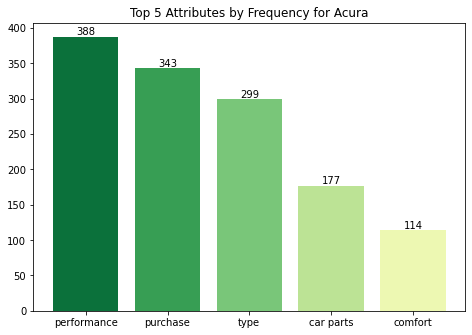

In [85]:
# create acura dataframe for bar plot
attributes = pd.DataFrame(["performance","purchase","type","car parts","comfort"],columns=['attributes'])
acura_performance = len(acura[acura['Attribute_Mentioned'].str.contains('performance')]['Attribute_Mentioned'])
acura_purchase = len(acura[acura['Attribute_Mentioned'].str.contains('purchase')]['Attribute_Mentioned'])
acura_type = len(acura[acura['Attribute_Mentioned'].str.contains('type')]['Attribute_Mentioned'])
acura_car_parts = len(acura[acura['Attribute_Mentioned'].str.contains('car parts')]['Attribute_Mentioned'])
acura_comfort = len(acura[acura['Attribute_Mentioned'].str.contains('comfort')]['Attribute_Mentioned'])
acura_attri_count = pd.DataFrame([acura_performance, acura_purchase, acura_type, acura_car_parts, acura_comfort],columns=['counts'])
acura_attri = pd.concat([attributes,acura_attri_count],axis=1)
acura_attri['counts']=acura_attri['counts'].fillna(0)

# bar plot of top 5 attributes for acura

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([0,0,1,1])    #  set up plot size and axes
k = ax.bar(acura_attri['attributes'],acura_attri['counts'],color = sns.color_palette('YlGn_r',5))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Top 5 Attributes by Frequency for Acura')
plt.show()

#### 2. Comparison Brand Frequency Barchart

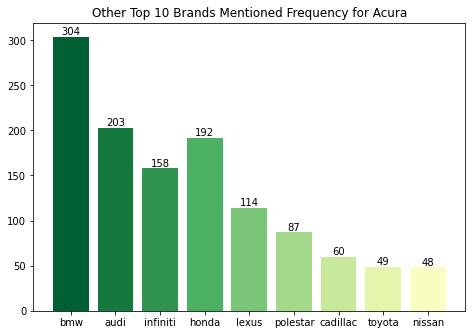

In [86]:
brands = pd.DataFrame(["bmw","audi","infiniti","honda","lexus","polestar","cadillac","toyota","nissan"],columns=['brands'])
acura_bmw = len(acura[acura['Brand_Mentioned'].str.contains('bmw')]['Brand_Mentioned'])
acura_audi = len(acura[acura['Brand_Mentioned'].str.contains('audi')]['Brand_Mentioned'])
acura_infiniti = len(acura[acura['Brand_Mentioned'].str.contains('infiniti')]['Brand_Mentioned'])
acura_honda = len(acura[acura['Brand_Mentioned'].str.contains('honda')]['Brand_Mentioned'])
acura_lexus = len(acura[acura['Brand_Mentioned'].str.contains('lexus')]['Brand_Mentioned'])
acura_polestar = len(acura[acura['Brand_Mentioned'].str.contains('polestar')]['Brand_Mentioned'])
acura_cadillac = len(acura[acura['Brand_Mentioned'].str.contains('cadillac')]['Brand_Mentioned'])
acura_toyota = len(acura[acura['Brand_Mentioned'].str.contains('toyota')]['Brand_Mentioned'])
acura_nissan = len(acura[acura['Brand_Mentioned'].str.contains('nissan')]['Brand_Mentioned'])
acura_brand_count = pd.DataFrame([acura_bmw,acura_audi,acura_infiniti,acura_honda,acura_lexus,acura_polestar,acura_cadillac,
                                 acura_toyota,acura_nissan],columns=['counts'])
acura_brand = pd.concat([brands,acura_brand_count],axis=1)
acura_brand['counts']=acura_brand['counts'].fillna(0)

# bar plot of other top 10 brands mentioned frequency for acura

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([0,0,1,1])    #  set up plot size and axes
k = ax.bar(acura_brand['brands'],acura_brand['counts'],color = sns.color_palette('YlGn_r',9))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Other Top 10 Brands Mentioned Frequency for Acura')
plt.show()

### audi
#### 1. Attributes Frequency barchart

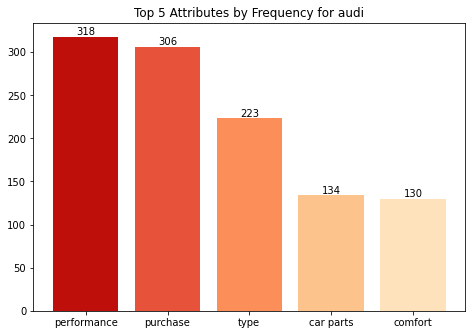

In [87]:
# create audi dataframe for bar plot
attributes = pd.DataFrame(["performance","purchase","type","car parts","comfort"],columns=['attributes'])
audi_performance = len(audi[audi['Attribute_Mentioned'].str.contains('performance')]['Attribute_Mentioned'])
audi_purchase = len(audi[audi['Attribute_Mentioned'].str.contains('purchase')]['Attribute_Mentioned'])
audi_type = len(audi[audi['Attribute_Mentioned'].str.contains('type')]['Attribute_Mentioned'])
audi_car_parts = len(audi[audi['Attribute_Mentioned'].str.contains('car parts')]['Attribute_Mentioned'])
audi_comfort = len(audi[audi['Attribute_Mentioned'].str.contains('comfort')]['Attribute_Mentioned'])
audi_attri_count = pd.DataFrame([audi_performance, audi_purchase, audi_type, audi_car_parts, audi_comfort],columns=['counts'])
audi_attri = pd.concat([attributes,audi_attri_count],axis=1)
audi_attri['counts']=audi_attri['counts'].fillna(0)

# bar plot of top 5 attributes for audi

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([0,0,1,1])    #  set up plot size and axes
k = ax.bar(audi_attri['attributes'],audi_attri['counts'],color = sns.color_palette('OrRd_r',5))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Top 5 Attributes by Frequency for audi')
plt.show()

#### 2. Comparison Brand Frequency Barchart

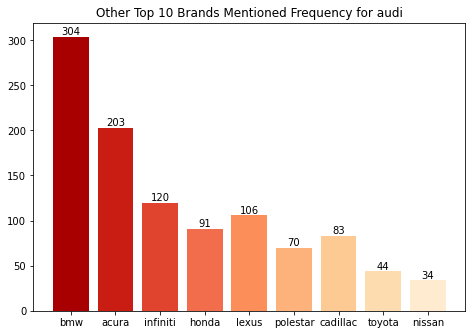

In [88]:
brands = pd.DataFrame(["bmw","acura","infiniti","honda","lexus","polestar","cadillac","toyota","nissan"],columns=['brands'])
audi_bmw = len(audi[audi['Brand_Mentioned'].str.contains('bmw')]['Brand_Mentioned'])
audi_acura = len(audi[audi['Brand_Mentioned'].str.contains('acura')]['Brand_Mentioned'])
audi_infiniti = len(audi[audi['Brand_Mentioned'].str.contains('infiniti')]['Brand_Mentioned'])
audi_honda = len(audi[audi['Brand_Mentioned'].str.contains('honda')]['Brand_Mentioned'])
audi_lexus = len(audi[audi['Brand_Mentioned'].str.contains('lexus')]['Brand_Mentioned'])
audi_polestar = len(audi[audi['Brand_Mentioned'].str.contains('polestar')]['Brand_Mentioned'])
audi_cadillac = len(audi[audi['Brand_Mentioned'].str.contains('cadillac')]['Brand_Mentioned'])
audi_toyota = len(audi[audi['Brand_Mentioned'].str.contains('toyota')]['Brand_Mentioned'])
audi_nissan = len(audi[audi['Brand_Mentioned'].str.contains('nissan')]['Brand_Mentioned'])
audi_brand_count = pd.DataFrame([audi_bmw,audi_acura,audi_infiniti,audi_honda,audi_lexus,audi_polestar,audi_cadillac,
                                 audi_toyota,audi_nissan],columns=['counts'])
audi_brand = pd.concat([brands,audi_brand_count],axis=1)
audi_brand['counts']=audi_brand['counts'].fillna(0)

# bar plot of other top 10 brands mentioned frequency for audi

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([0,0,1,1])    #  set up plot size and axes
k = ax.bar(audi_brand['brands'],audi_brand['counts'],color = sns.color_palette('OrRd_r',9))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Other Top 10 Brands Mentioned Frequency for audi')
plt.show()

### infiniti
#### 1. Attributes Frequency barchart

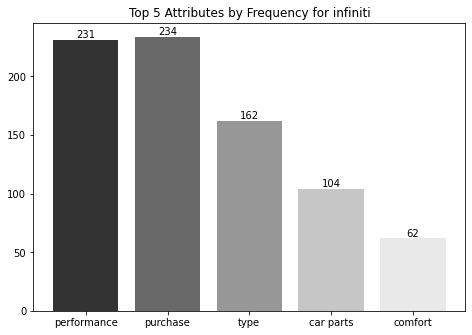

In [89]:
# create infiniti dataframe for bar plot
attributes = pd.DataFrame(["performance","purchase","type","car parts","comfort"],columns=['attributes'])
infiniti_performance = len(infiniti[infiniti['Attribute_Mentioned'].str.contains('performance')]['Attribute_Mentioned'])
infiniti_purchase = len(infiniti[infiniti['Attribute_Mentioned'].str.contains('purchase')]['Attribute_Mentioned'])
infiniti_type = len(infiniti[infiniti['Attribute_Mentioned'].str.contains('type')]['Attribute_Mentioned'])
infiniti_car_parts = len(infiniti[infiniti['Attribute_Mentioned'].str.contains('car parts')]['Attribute_Mentioned'])
infiniti_comfort = len(infiniti[infiniti['Attribute_Mentioned'].str.contains('comfort')]['Attribute_Mentioned'])
infiniti_attri_count = pd.DataFrame([infiniti_performance, infiniti_purchase, infiniti_type, infiniti_car_parts, infiniti_comfort],columns=['counts'])
infiniti_attri = pd.concat([attributes,infiniti_attri_count],axis=1)
infiniti_attri['counts']=infiniti_attri['counts'].fillna(0)

# bar plot of top 5 attributes for infiniti

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([0,0,1,1])    #  set up plot size and axes
k = ax.bar(infiniti_attri['attributes'],infiniti_attri['counts'],color = sns.color_palette('Greys_r',5))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Top 5 Attributes by Frequency for infiniti')
plt.show()

#### 2. Comparison Brand Frequency Barchart

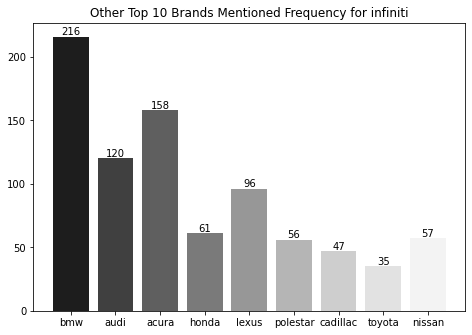

In [90]:
brands = pd.DataFrame(["bmw","audi","acura","honda","lexus","polestar","cadillac","toyota","nissan"],columns=['brands'])
infiniti_bmw = len(infiniti[infiniti['Brand_Mentioned'].str.contains('bmw')]['Brand_Mentioned'])
infiniti_audi = len(infiniti[infiniti['Brand_Mentioned'].str.contains('audi')]['Brand_Mentioned'])
infiniti_acura = len(infiniti[infiniti['Brand_Mentioned'].str.contains('acura')]['Brand_Mentioned'])
infiniti_honda = len(infiniti[infiniti['Brand_Mentioned'].str.contains('honda')]['Brand_Mentioned'])
infiniti_lexus = len(infiniti[infiniti['Brand_Mentioned'].str.contains('lexus')]['Brand_Mentioned'])
infiniti_polestar = len(infiniti[infiniti['Brand_Mentioned'].str.contains('polestar')]['Brand_Mentioned'])
infiniti_cadillac = len(infiniti[infiniti['Brand_Mentioned'].str.contains('cadillac')]['Brand_Mentioned'])
infiniti_toyota = len(infiniti[infiniti['Brand_Mentioned'].str.contains('toyota')]['Brand_Mentioned'])
infiniti_nissan = len(infiniti[infiniti['Brand_Mentioned'].str.contains('nissan')]['Brand_Mentioned'])
infiniti_brand_count = pd.DataFrame([infiniti_bmw,infiniti_audi,infiniti_acura,infiniti_honda,infiniti_lexus,infiniti_polestar,infiniti_cadillac,
                                 infiniti_toyota,infiniti_nissan],columns=['counts'])
infiniti_brand = pd.concat([brands,infiniti_brand_count],axis=1)
infiniti_brand['counts']=infiniti_brand['counts'].fillna(0)

# bar plot of other top 10 brands mentioned frequency for infiniti

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([0,0,1,1])    #  set up plot size and axes
k = ax.bar(infiniti_brand['brands'],infiniti_brand['counts'],color = sns.color_palette('Greys_r',9))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Other Top 10 Brands Mentioned Frequency for infiniti')
plt.show()

### honda
#### 1. Attributes Frequency barchart

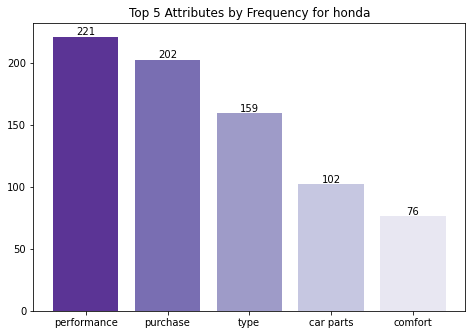

In [91]:
# create honda dataframe for bar plot
attributes = pd.DataFrame(["performance","purchase","type","car parts","comfort"],columns=['attributes'])
honda_performance = len(honda[honda['Attribute_Mentioned'].str.contains('performance')]['Attribute_Mentioned'])
honda_purchase = len(honda[honda['Attribute_Mentioned'].str.contains('purchase')]['Attribute_Mentioned'])
honda_type = len(honda[honda['Attribute_Mentioned'].str.contains('type')]['Attribute_Mentioned'])
honda_car_parts = len(honda[honda['Attribute_Mentioned'].str.contains('car parts')]['Attribute_Mentioned'])
honda_comfort = len(honda[honda['Attribute_Mentioned'].str.contains('comfort')]['Attribute_Mentioned'])
honda_attri_count = pd.DataFrame([honda_performance, honda_purchase, honda_type, honda_car_parts, honda_comfort],columns=['counts'])
honda_attri = pd.concat([attributes,honda_attri_count],axis=1)
honda_attri['counts']=honda_attri['counts'].fillna(0)

# bar plot of top 5 attributes for honda

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([0,0,1,1])    #  set up plot size and axes
k = ax.bar(honda_attri['attributes'],honda_attri['counts'],color = sns.color_palette('Purples_r',5))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Top 5 Attributes by Frequency for honda')
plt.show()

#### 2. Comparison Brand Frequency Barchart

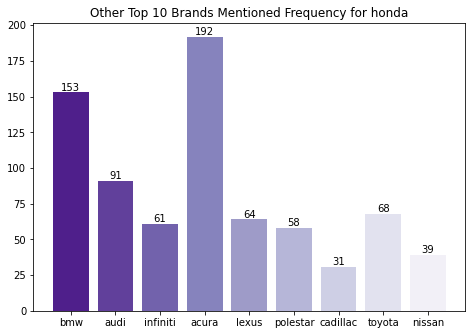

In [92]:
brands = pd.DataFrame(["bmw","audi","infiniti","acura","lexus","polestar","cadillac","toyota","nissan"],columns=['brands'])
honda_bmw = len(honda[honda['Brand_Mentioned'].str.contains('bmw')]['Brand_Mentioned'])
honda_audi = len(honda[honda['Brand_Mentioned'].str.contains('audi')]['Brand_Mentioned'])
honda_infiniti = len(honda[honda['Brand_Mentioned'].str.contains('infiniti')]['Brand_Mentioned'])
honda_acura = len(honda[honda['Brand_Mentioned'].str.contains('acura')]['Brand_Mentioned'])
honda_lexus = len(honda[honda['Brand_Mentioned'].str.contains('lexus')]['Brand_Mentioned'])
honda_polestar = len(honda[honda['Brand_Mentioned'].str.contains('polestar')]['Brand_Mentioned'])
honda_cadillac = len(honda[honda['Brand_Mentioned'].str.contains('cadillac')]['Brand_Mentioned'])
honda_toyota = len(honda[honda['Brand_Mentioned'].str.contains('toyota')]['Brand_Mentioned'])
honda_nissan = len(honda[honda['Brand_Mentioned'].str.contains('nissan')]['Brand_Mentioned'])
honda_brand_count = pd.DataFrame([honda_bmw,honda_audi,honda_infiniti,honda_acura,honda_lexus,honda_polestar,honda_cadillac,
                                 honda_toyota,honda_nissan],columns=['counts'])
honda_brand = pd.concat([brands,honda_brand_count],axis=1)
honda_brand['counts']=honda_brand['counts'].fillna(0)

# bar plot of other top 10 brands mentioned frequency for honda

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([0,0,1,1])    #  set up plot size and axes
k = ax.bar(honda_brand['brands'],honda_brand['counts'],color = sns.color_palette('Purples_r',9))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Other Top 10 Brands Mentioned Frequency for honda')
plt.show()